This notebook supports the equations that govern contaminant uptake and impacts on the biology within the Salish Sea Atlantis model. It shows the 1-day output of simulations after injecting PAH components of oil into the water column, to observe biological uptake, as well as non-lethal and lethal impacts relative to a control simulation with no contaminants injected.

Half lives

| PAH Concentration	|	Naphthalene |	Phenanthrene | Pyrene |	Benzo(a)pyrene |
|-------------------|---------------|-----------------|--------|----------|
| Half life (secs)	|	259200 |	3628800	| 20476800	| 19353600 |
| Half life (days)	|	3	| 42 |	237 |	224 |

In [1]:
import os
import re
import xarray as xr
import numpy as np
import itertools
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
from pathlib import Path
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot

In [2]:
# Read in salish sea atlantis output files.
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/highres-control-3y/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True)
time = np.ma.filled(control.variables['t'])

In [3]:
scenario_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1')

## All Scenarios

In [4]:
line_styles = itertools.cycle(('-', '--', '-.', ':'))#,(5, (10, 3)),
#    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))

In [5]:

scenario_paths = sorted([p for p in scenario_root.glob('highres-scenario_*/outputSalishSea.nc')])
scenario_names = []
for path in scenario_paths:
    print(path.parent.stem, groups.conditions[str(path.parent.stem).split(sep = '_')[3]])
    nm = str(path.parent.stem).split(sep='_')
    if nm[1] == '4a':
        scenario_loc = 'AP-'
    elif nm[1] == '5b':
        scenario_loc = 'TP-'
    elif nm[1] == '6a':
        scenario_loc = 'EB-'
    elif nm[1] == '7a':
        scenario_loc = 'JF-'
    scenario_names.append(scenario_loc+'-'+str(nm[2]))

highres-scenario_4a_1_2019-07-04 low Fraser flow spring tide summer
highres-scenario_4a_2_2019-07-10 low Fraser flow neap tide summer
highres-scenario_4a_3_2020-07-22 high Fraser flow spring tide summer
highres-scenario_4a_4_2020-07-12 high Fraser flow neap tide summer
highres-scenario_5b_1_2019-01-20 low Fraser flow spring tide winter
highres-scenario_5b_2_2019-01-14 low Fraser flow neap tide winter
highres-scenario_5b_3_2020-01-24 high Fraser flow spring tide winter
highres-scenario_5b_4_2020-01-16 high Fraser flow neap tide winter
highres-scenario_6a_1_2019-07-16 low Fraser flow spring tide summer
highres-scenario_6a_2_2019-07-25 low Fraser flow neap tide summer
highres-scenario_6a_3_2020-07-21 high Fraser flow spring tide summer
highres-scenario_6a_4_2020-07-13 high Fraser flow neap tide summer
highres-scenario_7a_1_2019-01-21 low Fraser flow spring tide winter
highres-scenario_7a_2_2019-01-26 low Fraser flow neap tide winter
highres-scenario_7a_3_2020-01-11 high Fraser flow spring

In [6]:
scenario_datasets = [xr.open_dataset(scen,decode_cf=True) for scen in scenario_paths]

In [7]:
start = 0
end = time.size-1

### PAH Concdentrations in Habitat

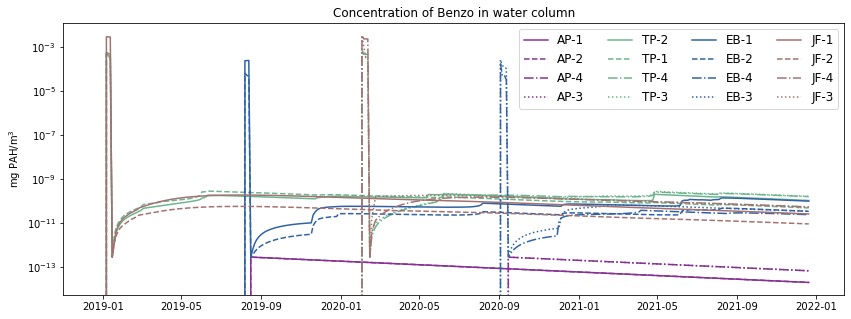

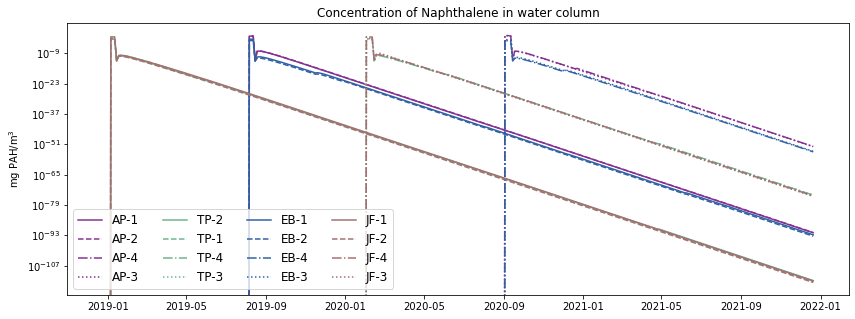

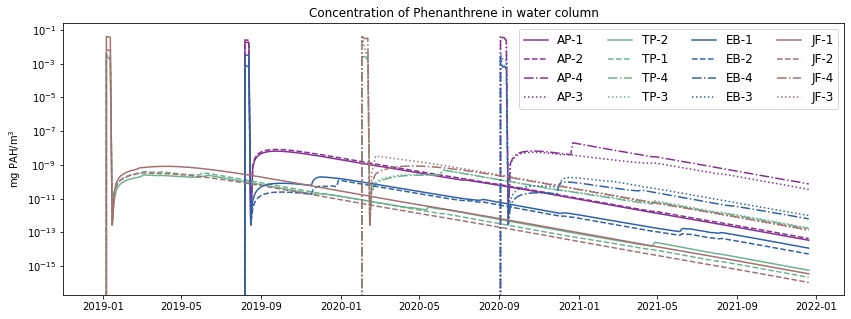

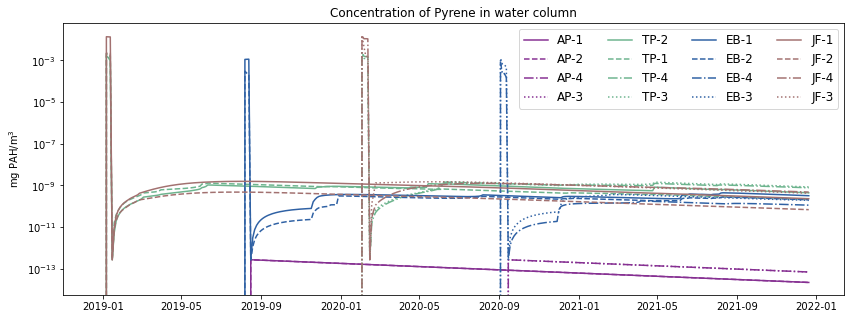

In [28]:
for pah in groups.pahs:
    fig, ax = plt.subplots(figsize = (14,5))
    for scenario, name in zip(scenario_datasets,scenario_names):
        contam_tbl = scenario.variables[str(pah)][start:end,:,0:6]
        contam_tb = contam_tbl.sum(axis=2)
        contam_t = contam_tb.sum(axis=1)
        if 'AP' in name:
            hex_colour = '#863092'
        elif 'TP' in name:
            hex_colour = '#6DB48E'
        elif 'EB' in name:
            hex_colour = '#2F61A4'
        elif 'JF' in name:
            hex_colour = '#A27170'
        ax.semilogy(scenario.t[start:end], contam_t, color=hex_colour, linestyle=next(line_styles))
    ax.set_title('Concentration of '+ pah +' in water column', fontsize = 12)
    ax.set_ylabel('mg PAH/m$^3$')
    ax.legend(scenario_names, fontsize=12, ncol=4); #loc='upper left', bbox_to_anchor=(1.05, 1), loc='upper center', 

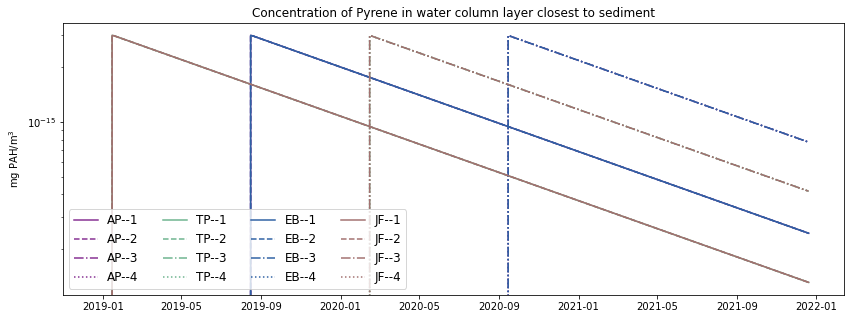

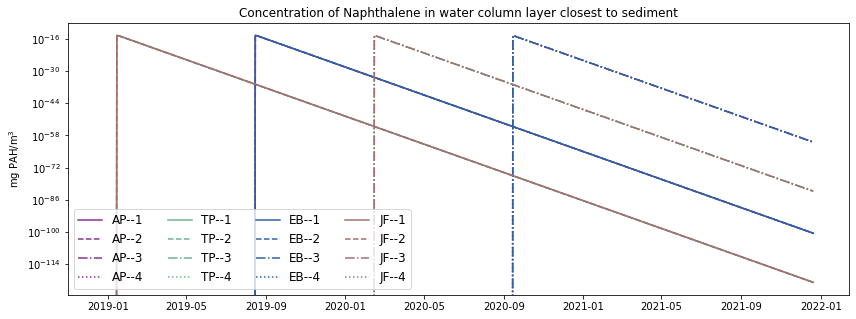

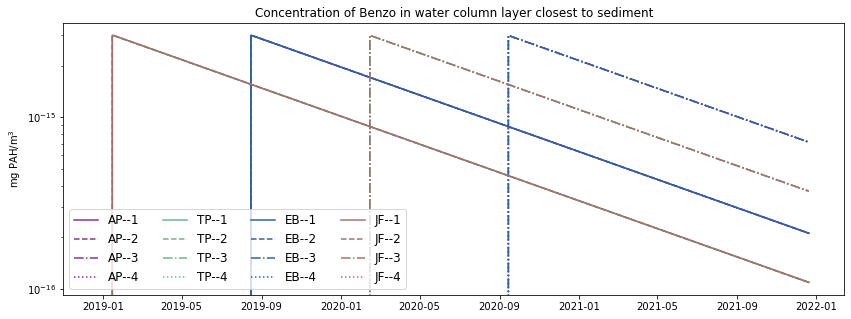

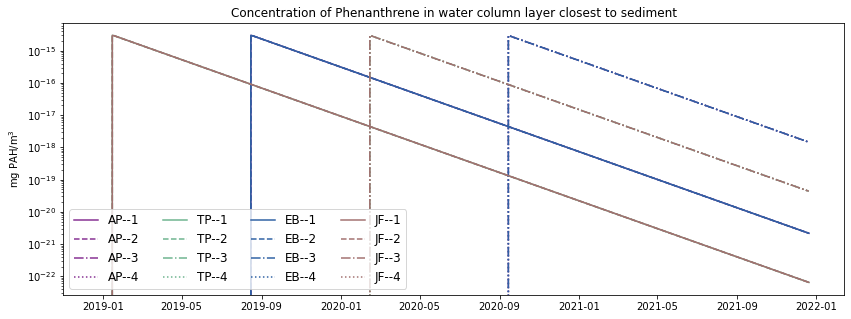

In [14]:
for pah in groups.pahs:
    fig, ax = plt.subplots(figsize = (14,5))
    for scenario, name in zip(scenario_datasets,scenario_names):
        contam_tb = scenario.variables[str(pah)][start:end,:,0]
        contam_t = contam_tb.sum(axis=1)
        if 'AP' in name:
            hex_colour = '#863092'
        elif 'TP' in name:
            hex_colour = '#6DB48E'
        elif 'EB' in name:
            hex_colour = '#2F61A4'
        elif 'JF' in name:
            hex_colour = '#A27170'
        ax.semilogy(scenario.t[start:end], contam_t, color=hex_colour, linestyle=next(line_styles))
    ax.set_title('Concentration of '+ pah +' in water column layer closest to sediment', fontsize = 12)
    ax.set_ylabel('mg PAH/m$^3$')
    ax.legend(scenario_names, fontsize=12, ncol=4); #loc='upper left', bbox_to_anchor=(1.05, 1), loc='upper center', 

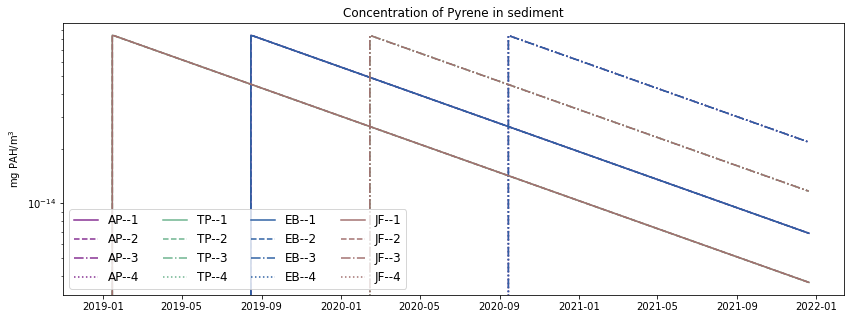

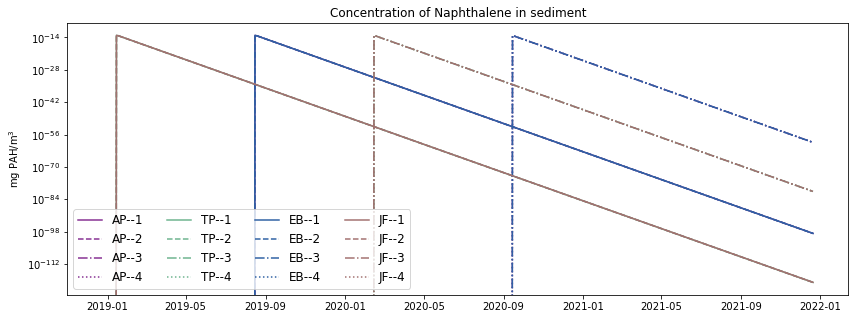

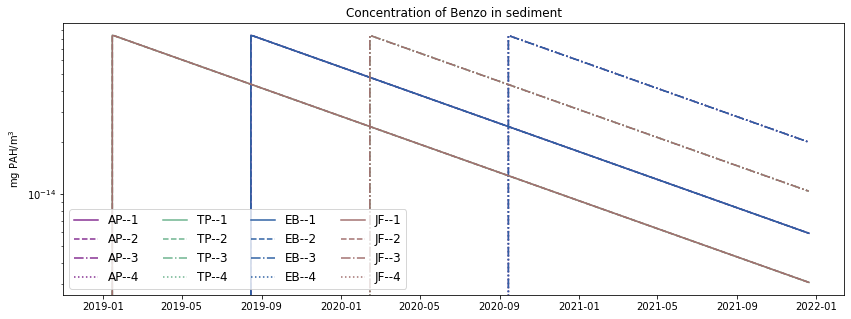

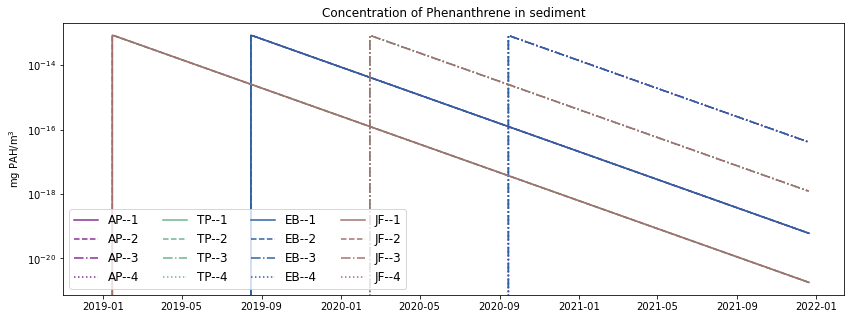

In [11]:
for pah in groups.pahs:
    fig, ax = plt.subplots(figsize = (14,5))
    for scenario, name in zip(scenario_datasets,scenario_names):
        contam_tb = scenario.variables[str(pah)][start:end,:,6]
        contam_t = contam_tb.sum(axis=1)
        if 'AP' in name:
            hex_colour = '#863092'
        elif 'TP' in name:
            hex_colour = '#6DB48E'
        elif 'EB' in name:
            hex_colour = '#2F61A4'
        elif 'JF' in name:
            hex_colour = '#A27170'
        ax.semilogy(scenario.t[start:end], contam_t, color=hex_colour, linestyle=next(line_styles))
    ax.set_title('Concentration of '+ pah +' in sediment', fontsize = 12)
    ax.set_ylabel('mg PAH/m$^3$')
    ax.legend(scenario_names, fontsize=12, ncol=4); #loc='upper left', bbox_to_anchor=(1.05, 1), loc='upper center', 

/home/rlovindeer/conda_envs/salishsea-tools/lib/python3.9/site-packages/matplotlib_inline/backend_inline.py:234: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


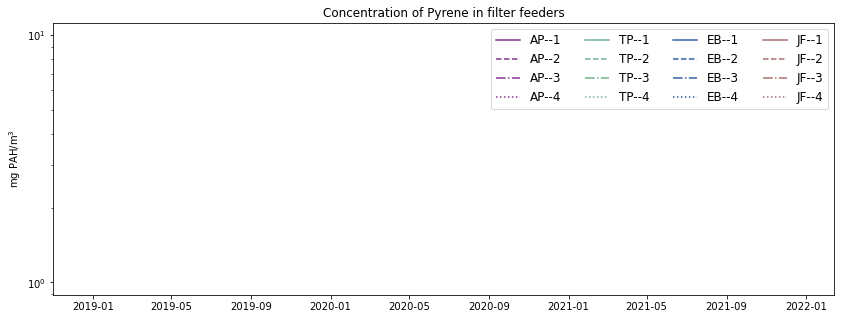

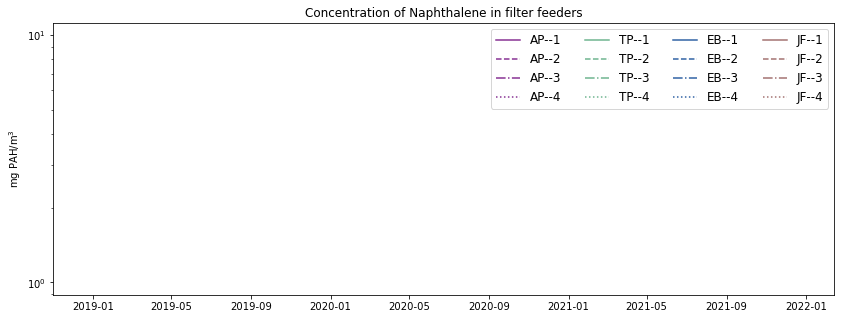

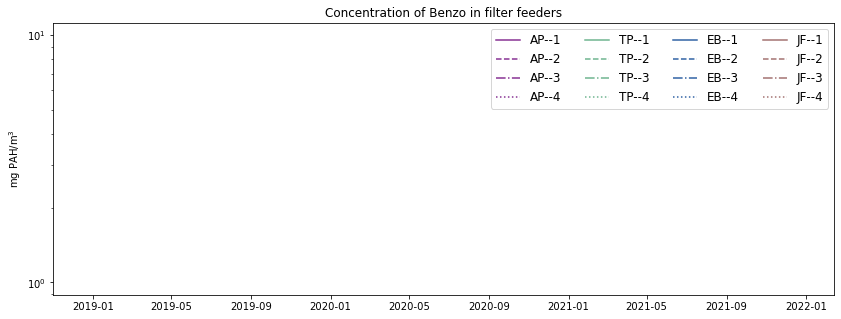

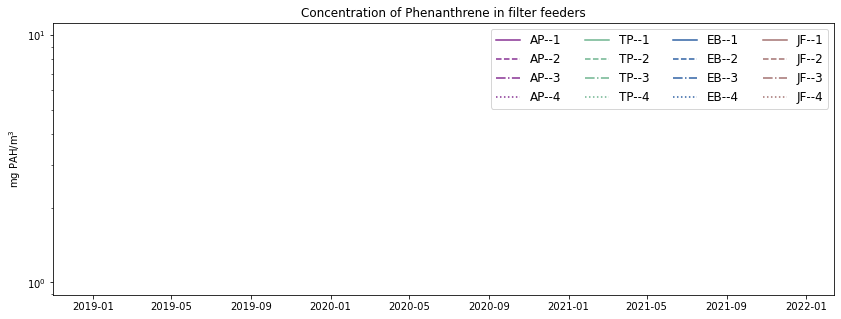

In [23]:
for pah in groups.pahs:
    fig, ax = plt.subplots(figsize = (14,5))
    for scenario, name in zip(scenario_datasets,scenario_names):
        contam_tb = scenario.variables['Filter_feeder_'+str(pah)][start:end,:]
        contam_t = contam_tb.sum(axis=1)
        if 'AP' in name:
            hex_colour = '#863092'
        elif 'TP' in name:
            hex_colour = '#6DB48E'
        elif 'EB' in name:
            hex_colour = '#2F61A4'
        elif 'JF' in name:
            hex_colour = '#A27170'
        ax.semilogy(scenario.t[start:end], contam_t, color=hex_colour, linestyle=next(line_styles))
    ax.set_title('Concentration of '+ pah +' in filter feeders', fontsize = 12)
    ax.set_ylabel('mg PAH/m$^3$')
    ax.legend(scenario_names, fontsize=12, ncol=4); #loc='upper left', bbox_to_anchor=(1.05, 1), loc='upper center', 

The concentration of contaminants in the water column layer closest to the sediment is too low to trigger uptake by the benthic species for these runs. 

### Impact results

In [119]:
def compare_scenario_phytoplankton(scenario_datasets=scenario_datasets, scenario_names=scenario_names,boxes=groups.salish_sea, start=start, end=end, y_min=None, y_max=None,ncol=4): 
    
    names = ['control']

    fig, ax = plt.subplots(figsize = (14,5))

    pelagic_control_tbl = np.ma.filled(control.variables['Diatom_N'][start:end,boxes,0:6], np.nan) + np.ma.filled(control.variables['PicoPhytopl_N'][start:end,boxes,0:6], np.nan)
    pelagic_control = pelagic_control_tbl.sum(axis=(1,2))
    control_ratio = (pelagic_control / pelagic_control-1)*100
    ax.plot(control.t[start:end], control_ratio, 'k', linewidth = 2)

    for scenario, name in zip(scenario_datasets, scenario_names):
        if 'AP' in name:
            hex_colour = '#863092'
        elif 'TP' in name:
            hex_colour = '#6DB48E'
        elif 'EB' in name:
            hex_colour = '#2F61A4'
        elif 'JF' in name:
            hex_colour = '#A27170'
        
        names.append(name)

        pelagic_oiled_tbl = np.ma.filled(scenario.variables['Diatom_N'][start:end,boxes,0:6], np.nan) + np.ma.filled(scenario.variables['PicoPhytopl_N'][start:end,boxes,0:6], np.nan)
        pelagic_oiled = pelagic_oiled_tbl.sum(axis=(1,2))
        ratio = (pelagic_oiled / pelagic_control-1)*100
        ax.plot(scenario.t[start:end], ratio, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
    #ax.fill_between(scenario.t[start:end], -0.3, 0.3,
        #color='grey', alpha=0.3, label='Model Sensitivity')
    
    plt.ylabel('Percent (%) change', fontsize=12)
    ax.set_title('Phytoplankton')
    ax.set_ylim([y_min, y_max])
    ax.legend(names, fontsize=12, ncol=ncol); #bbox_to_anchor=(1.05, 1)

In [120]:
def compare_scenario_zooplankton(scenario_datasets=scenario_datasets, scenario_names=scenario_names, boxes=groups.salish_sea, start=start, end=end, y_min=None, y_max=None,ncol=4): 
    
    names = ['control']

    fig, ax = plt.subplots(figsize = (14,5))

    pelagic_control_tbl = np.ma.filled(control.variables['MicroZoo_N'][start:end,boxes,0:6], np.nan) + np.ma.filled(control.variables['Zoo_N'][start:end,boxes,0:6], np.nan) + np.ma.filled(control.variables['Carniv_Zoo_N'][start:end,boxes,0:6], np.nan) + np.ma.filled(control.variables['Gelat_Zoo_N'][start:end,boxes,0:6], np.nan)
    pelagic_control = pelagic_control_tbl.sum(axis=(1,2))
    control_ratio = (pelagic_control / pelagic_control-1)*100
    ax.plot(control.t[start:end], control_ratio, 'k', linewidth = 2)

    for scenario, name in zip(scenario_datasets, scenario_names):
        if 'AP' in name:
            hex_colour = '#863092'
        elif 'TP' in name:
            hex_colour = '#6DB48E'
        elif 'EB' in name:
            hex_colour = '#2F61A4'
        elif 'JF' in name:
            hex_colour = '#A27170'
        
        names.append(name)

        pelagic_oiled_tbl = np.ma.filled(scenario.variables['MicroZoo_N'][start:end,boxes,0:6], np.nan) + np.ma.filled(scenario.variables['Zoo_N'][start:end,boxes,0:6], np.nan) + np.ma.filled(scenario.variables['Carniv_Zoo_N'][start:end,boxes,0:6], np.nan) + np.ma.filled(scenario.variables['Gelat_Zoo_N'][start:end,boxes,0:6], np.nan)
        pelagic_oiled = pelagic_oiled_tbl.sum(axis=(1,2))
        ratio = (pelagic_oiled / pelagic_control-1)*100
        ax.plot(scenario.t[start:end], ratio, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
    #ax.fill_between(scenario.t[start:end], -1, 1,
        #color='grey', alpha=0.3, label='Model Sensitivity')
    
    plt.ylabel('Percent (%) change', fontsize=12)
    ax.set_title('Zooplankton')
    ax.set_ylim([y_min, y_max])
    ax.legend(names, fontsize=12, ncol=ncol); #bbox_to_anchor=(1.05, 1), loc='lower right'

In [125]:
def plot_scenario_biomass_phytoplankton(scenario_datasets=scenario_datasets, scenario_names=scenario_names,boxes=groups.salish_sea, start=start, end=end, y_min=None, y_max=None, ncol=4, alpha=0.6): 
    
    names = ['control']

    fig, ax = plt.subplots(figsize = (14,5))

    pelagic_control_tbl = np.ma.filled(control.variables['Diatom_N'][start:end,boxes,0:6], np.nan) + np.ma.filled(control.variables['PicoPhytopl_N'][start:end,boxes,0:6], np.nan)
    pelagic_control = pelagic_control_tbl.sum(axis=(1,2))
    #control_ratio = (pelagic_control / pelagic_control-1)*100
    ax.plot(control.t[start:end], pelagic_control, 'k', linewidth = 2)

    for scenario, name in zip(scenario_datasets, scenario_names):
        if 'AP' in name:
            hex_colour = '#863092'
        elif 'TP' in name:
            hex_colour = '#6DB48E'
        elif 'EB' in name:
            hex_colour = '#2F61A4'
        elif 'JF' in name:
            hex_colour = '#A27170'
        
        names.append(name)

        pelagic_oiled_tbl = np.ma.filled(scenario.variables['Diatom_N'][start:end,boxes,0:6], np.nan) + np.ma.filled(scenario.variables['PicoPhytopl_N'][start:end,boxes,0:6], np.nan)
        pelagic_oiled = pelagic_oiled_tbl.sum(axis=(1,2))
        #ratio = (pelagic_oiled / pelagic_control-1)*100
        ax.plot(scenario.t[start:end], pelagic_oiled, linewidth = 2, alpha=alpha, color=hex_colour, linestyle=next(line_styles))
    #ax.fill_between(scenario.t[start:end], -0.3, 0.3,
        #color='grey', alpha=0.3, label='Model Sensitivity')
    
    plt.ylabel('Percent (%) change', fontsize=12)
    ax.set_title('Phytoplankton')
    ax.set_ylim([y_min, y_max])
    ax.legend(names, fontsize=12, ncol=ncol); #bbox_to_anchor=(1.05, 1)

In [126]:
def plot_scenario_biomass_zooplankton(scenario_datasets=scenario_datasets, scenario_names=scenario_names,boxes=groups.salish_sea, start=start, end=end, y_min=None, y_max=None, ncol=4, alpha=0.6): 
    
    names = ['control']

    fig, ax = plt.subplots(figsize = (14,5))

    pelagic_control_tbl = np.ma.filled(control.variables['MicroZoo_N'][start:end,boxes,0:6], np.nan) + np.ma.filled(control.variables['Zoo_N'][start:end,boxes,0:6], np.nan) + np.ma.filled(control.variables['Carniv_Zoo_N'][start:end,boxes,0:6], np.nan) + np.ma.filled(control.variables['Gelat_Zoo_N'][start:end,boxes,0:6], np.nan)
    pelagic_control = pelagic_control_tbl.sum(axis=(1,2))
    #control_ratio = (pelagic_control / pelagic_control-1)*100
    ax.plot(control.t[start:end], pelagic_control, 'k', linewidth = 2)

    for scenario, name in zip(scenario_datasets, scenario_names):
        if 'AP' in name:
            hex_colour = '#863092'
        elif 'TP' in name:
            hex_colour = '#6DB48E'
        elif 'EB' in name:
            hex_colour = '#2F61A4'
        elif 'JF' in name:
            hex_colour = '#A27170'
        
        names.append(name)

        pelagic_oiled_tbl = np.ma.filled(scenario.variables['MicroZoo_N'][start:end,boxes,0:6], np.nan) + np.ma.filled(scenario.variables['Zoo_N'][start:end,boxes,0:6], np.nan) + np.ma.filled(scenario.variables['Carniv_Zoo_N'][start:end,boxes,0:6], np.nan) + np.ma.filled(scenario.variables['Gelat_Zoo_N'][start:end,boxes,0:6], np.nan)
        pelagic_oiled = pelagic_oiled_tbl.sum(axis=(1,2))
        #ratio = (pelagic_oiled / pelagic_control-1)*100
        ax.plot(scenario.t[start:end], pelagic_oiled, linewidth = 2, alpha=alpha, color=hex_colour, linestyle=next(line_styles))
    #ax.fill_between(scenario.t[start:end], -0.3, 0.3,
        #color='grey', alpha=0.3, label='Model Sensitivity')
    
    plt.ylabel('Percent (%) change', fontsize=12)
    ax.set_title('Zooplankton')
    ax.set_ylim([y_min, y_max])
    ax.legend(names, fontsize=12, ncol=ncol); #bbox_to_anchor=(1.05, 1)

In [72]:
def compare_scenario_vertebrates(bio_group, scenario_datasets=scenario_datasets, scenario_names=scenario_names,boxes=groups.salish_sea, start=start, end=end, y_min=None, y_max=None): 
    
    names = ['control']

    fig, ax = plt.subplots(figsize = (14,5))

    pelagic_control_tbl = np.ma.filled(control.variables[bio_group + '_N'][start:end,boxes,0:6], np.nan)
    pelagic_control = pelagic_control_tbl.sum(axis=(1,2))
    control_ratio = (pelagic_control / pelagic_control-1)*100
    ax.plot(control.t[start:end], control_ratio, 'k', linewidth = 2)

    for scenario, name in zip(scenario_datasets, scenario_names):
        if 'AP' in name:
            hex_colour = '#863092'
        elif 'TP' in name:
            hex_colour = '#6DB48E'
        elif 'EB' in name:
            hex_colour = '#2F61A4'
        elif 'JF' in name:
            hex_colour = '#A27170'
        
        names.append(name)

        sum_ratio = 0
        
        numCohorts = groups.cohorts[bio_group]
        for cohort in range (1, numCohorts+1):

            new_species = bio_group + str(cohort)
        
            o_numbers_tbl = np.ma.filled(scenario.variables[new_species + '_Nums'][start:end, boxes, 0:6], np.nan)
            o_structuralN_tbl = np.ma.filled(scenario.variables[new_species +'_StructN'][start:end, boxes, 0:6], np.nan)
            o_reservedN_tbl = np.ma.filled(scenario.variables[new_species +'_ResN'][start:end, boxes, 0:6], np.nan)

            c_numbers_tbl = np.ma.filled(control.variables[new_species + '_Nums'][start:end, boxes, 0:6], np.nan)
            c_structuralN_tbl = np.ma.filled(control.variables[new_species +'_StructN'][start:end, boxes, 0:6], np.nan)
            c_reservedN_tbl = np.ma.filled(control.variables[new_species +'_ResN'][start:end, boxes, 0:6], np.nan)

            o_weightatage_tbl = (o_structuralN_tbl + o_reservedN_tbl) * o_numbers_tbl 
            o_weightatage = o_weightatage_tbl.sum(axis=(1,2))

            c_weightatage_tbl = (c_structuralN_tbl + c_reservedN_tbl) * c_numbers_tbl 
            c_weightatage = c_weightatage_tbl.sum(axis=(1,2))

            #difference = o_weightatage_tb.sum(axis=1) - c_weightatage_tb.sum(axis=1) 
            ratio = (o_weightatage / c_weightatage - 1) * 100
            #print(ratio)
            sum_ratio = sum_ratio + ratio

        ax.plot(scenario.t[start:end], sum_ratio/numCohorts, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
    #ax.fill_between(scenario.t[start:end], -groups.sensitivity[species], groups.sensitivity[species],
        #color='grey', alpha=0.3, label='Model Sensitivity')
    
    plt.ylabel('Percent (%) change', fontsize=12)
    ax.set_title(bio_group)
    ax.set_ylim([y_min, y_max])
    ax.legend(names, fontsize=12, ncol=4); #bbox_to_anchor=(1.05, 1), loc='lower right'

In [73]:
def compare_scenarios_benthic_N(bio_group, scenario_datasets=scenario_datasets, scenario_names=scenario_names,boxes=groups.salish_sea, start=start, end=end, y_min=None, y_max=None): 

    names = ['control']

    fig, ax = plt.subplots(figsize = (14,3))

    pelagic_control = np.ma.filled(control.variables[bio_group + '_N'][start:end,boxes], np.nan)
    pelagic_control = pelagic_control.sum(axis=1)
    control_ratio = (pelagic_control / pelagic_control-1)*100
    ax.plot(control.t[start:end], control_ratio, 'k', linewidth = 2)

    for scenario, name in zip(scenario_datasets, scenario_names):
        if 'AP' in name:
            hex_colour = '#863092'
        elif 'TP' in name:
            hex_colour = '#6DB48E'
        elif 'EB' in name:
            hex_colour = '#2F61A4'
        elif 'JF' in name:
            hex_colour = '#A27170'
        
        names.append(name)

        pelagic_oiled = np.ma.filled(scenario.variables[bio_group + '_N'][start:end,boxes], np.nan) # tonnes
        pelagic_oiled = pelagic_oiled.sum(axis=1) 
        ratio = (pelagic_oiled / pelagic_control-1)*100
        ax.plot(scenario.t[start:end], ratio, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
    ax.fill_between(scenario.t[start:end], -groups.sensitivity[species], groups.sensitivity[species],
        color='grey', alpha=0.3, label='Model Sensitivity')
    
    plt.ylabel('Percent (%) change', fontsize=12)
    ax.set_title(species)
    ax.set_ylim([y_min, y_max])
    ax.legend(names, bbox_to_anchor=(1.05, 1), loc='upper center', fontsize=12); 

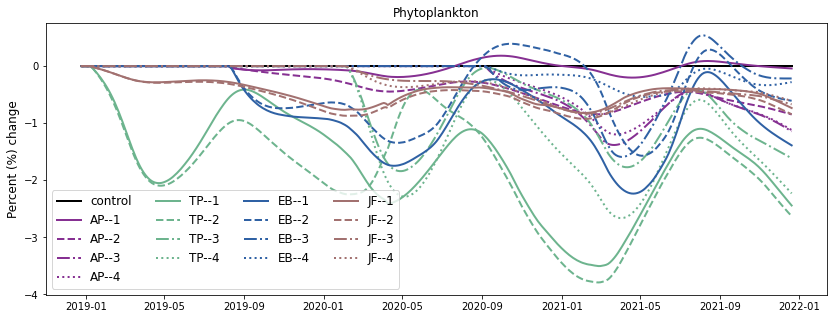

In [51]:
compare_scenario_phytoplankton()

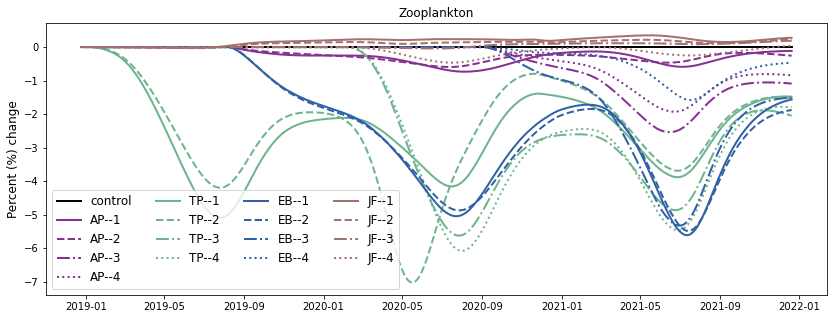

In [52]:
compare_scenario_zooplankton()

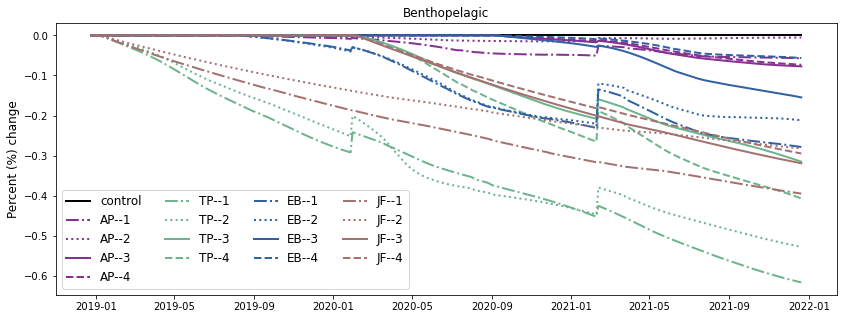

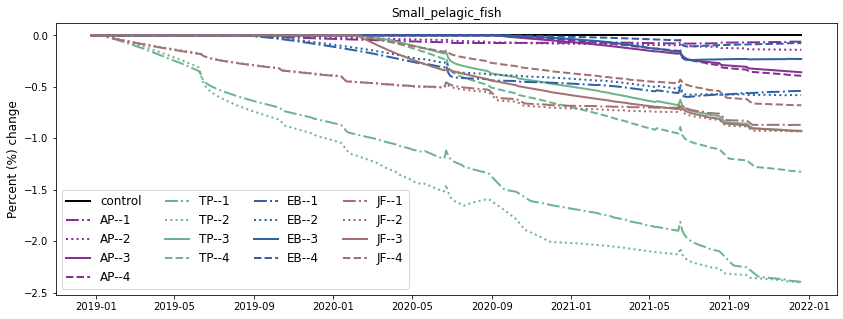

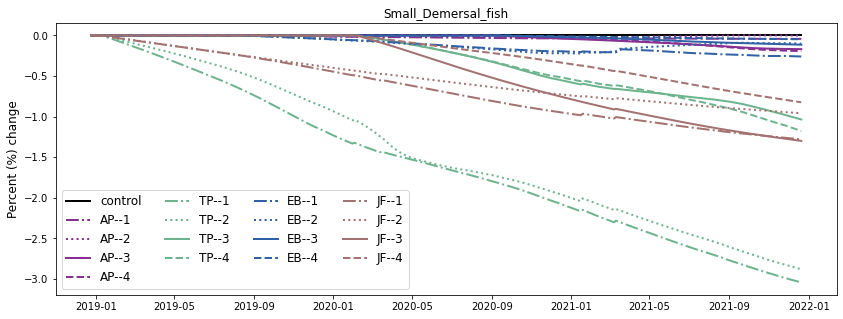

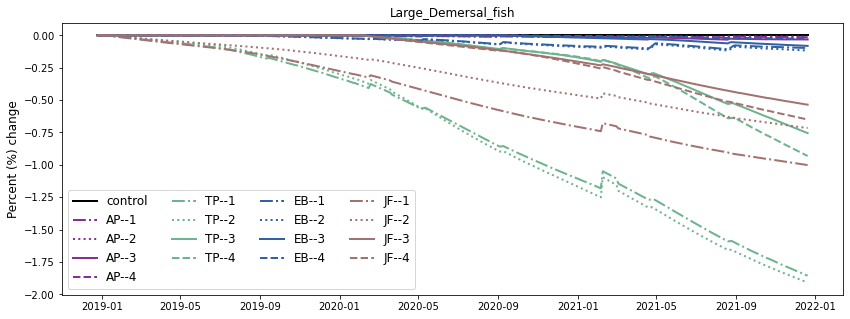

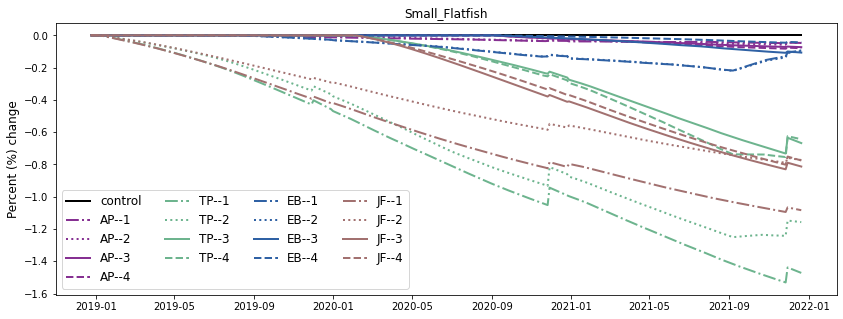

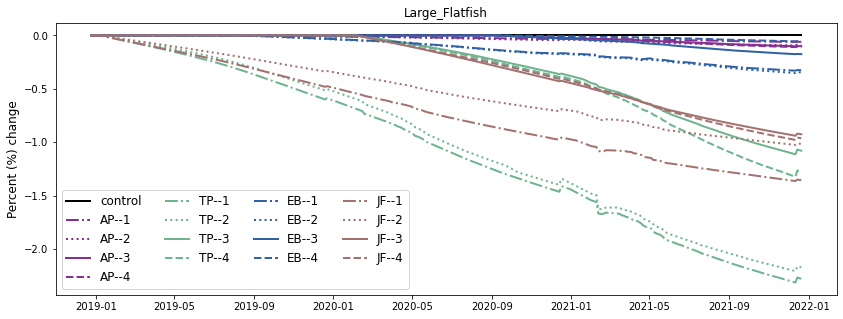

In [66]:
for species in groups.other_fish:
    compare_scenario_vertebrates(groups.other_fish[species])

## Individual Scenarios

In [78]:
Turn_Point = [1, 2, 3, 4, 5, 6, 7, 8, 9, 60, 33, 66]
Active_Pass = [60, 62, 63]
English_Bay = [75, 80]
Jstrait = [1, 2]

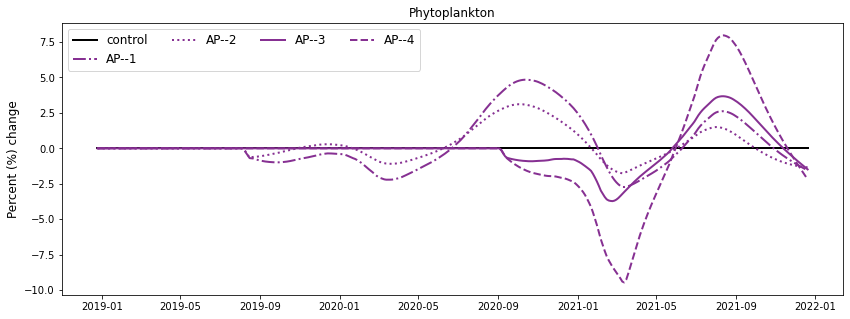

In [105]:
compare_scenario_phytoplankton(scenario_datasets[0:4], scenario_names[0:4],boxes=Active_Pass, ncol=5)

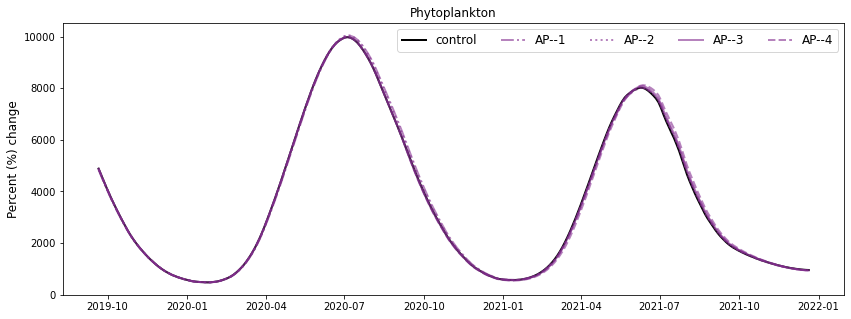

In [116]:
plot_scenario_biomass_phytoplankton(scenario_datasets[0:4], scenario_names[0:4],boxes=Active_Pass, start=90, ncol=5)

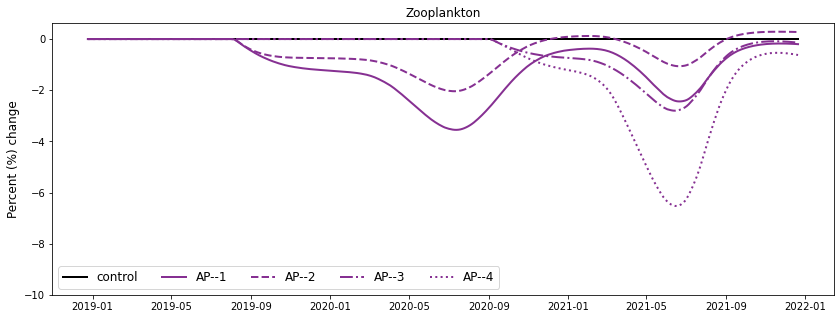

In [144]:
compare_scenario_zooplankton(scenario_datasets[0:4], scenario_names[0:4],boxes=Active_Pass, ncol=5, y_min=-10)

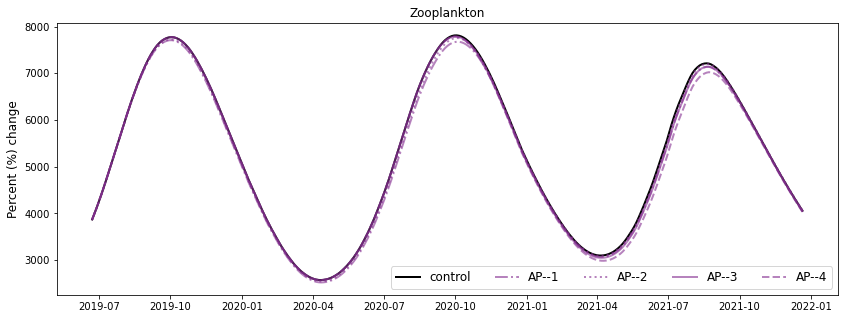

In [118]:
plot_scenario_biomass_zooplankton(scenario_datasets[0:4], scenario_names[0:4],boxes=Active_Pass, start=60,ncol=5)

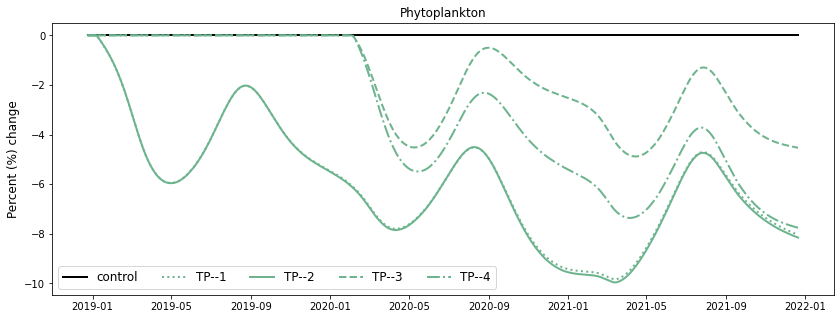

In [122]:
compare_scenario_phytoplankton(scenario_datasets[4:8], scenario_names[4:8],boxes=Turn_Point, ncol=5)

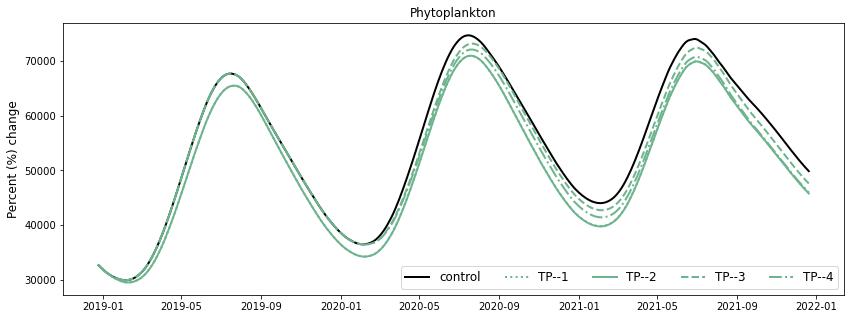

In [129]:
plot_scenario_biomass_phytoplankton(scenario_datasets[4:8], scenario_names[4:8],boxes=Turn_Point, start=0, ncol=5, alpha=1)

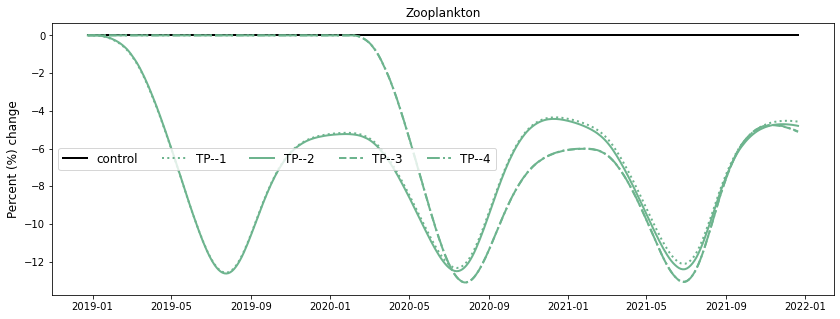

In [130]:
compare_scenario_zooplankton(scenario_datasets[4:8], scenario_names[4:8],boxes=Turn_Point, ncol=5)

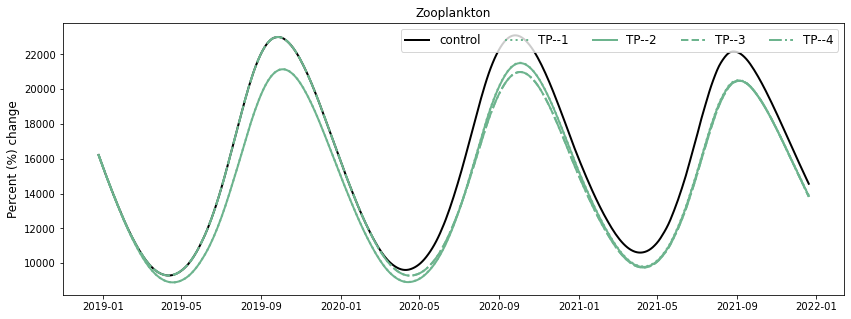

In [131]:
plot_scenario_biomass_zooplankton(scenario_datasets[4:8], scenario_names[4:8],boxes=Turn_Point, start=0, ncol=5, alpha=1)

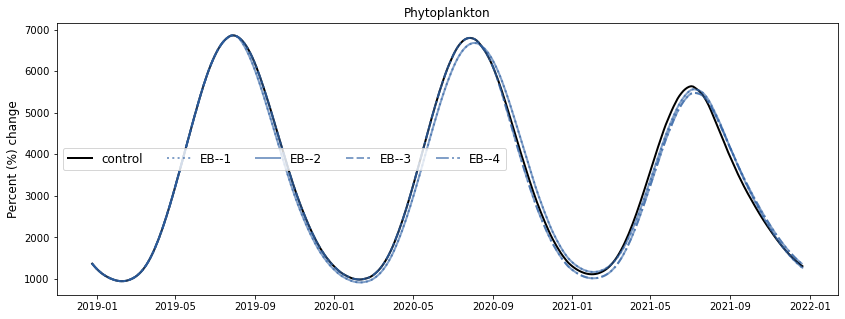

In [134]:
plot_scenario_biomass_phytoplankton(scenario_datasets[8:12], scenario_names[8:12],boxes=English_Bay, ncol=5)

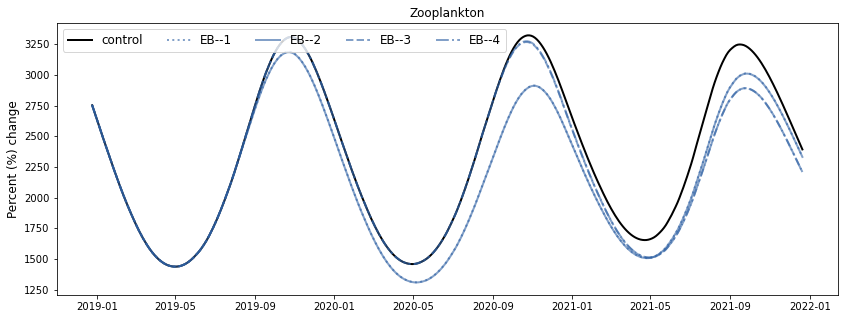

In [133]:
plot_scenario_biomass_zooplankton(scenario_datasets[8:12], scenario_names[8:12],boxes=English_Bay, ncol=5)

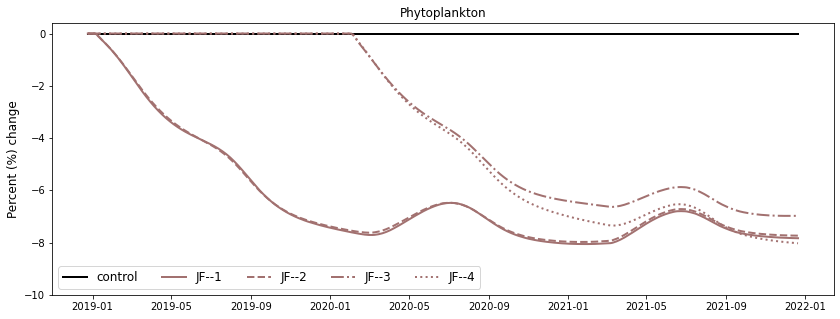

In [142]:
compare_scenario_phytoplankton(scenario_datasets[12:16], scenario_names[12:16],boxes=Jstrait, ncol=5, y_min=-10)

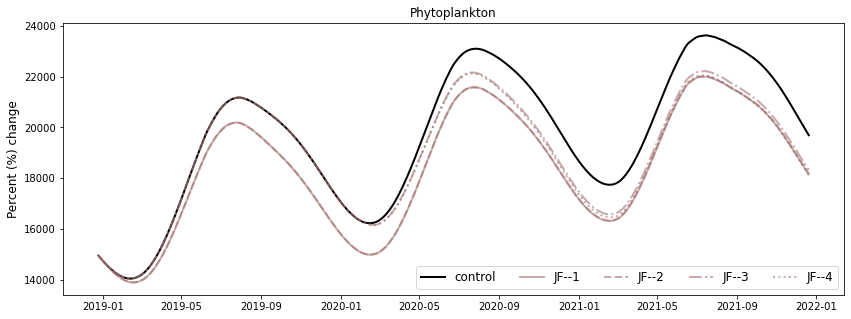

In [137]:
plot_scenario_biomass_phytoplankton(scenario_datasets[12:16], scenario_names[12:16],boxes=Jstrait, ncol=5)

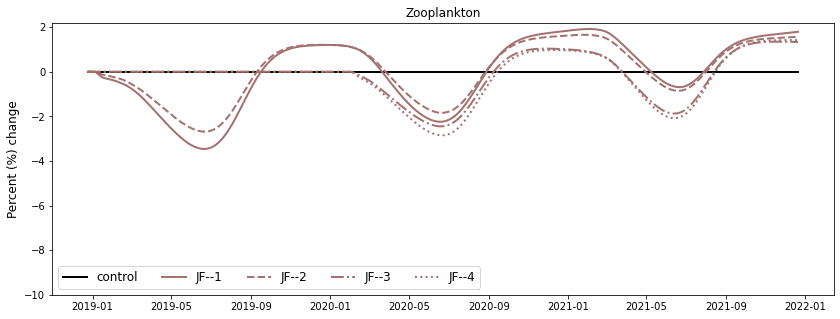

In [143]:
compare_scenario_zooplankton(scenario_datasets[12:16], scenario_names[12:16],boxes=Jstrait, ncol=5, y_min=-10)

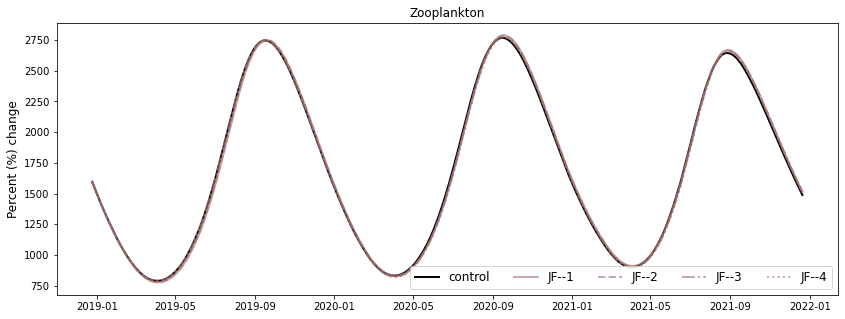

In [138]:
plot_scenario_biomass_zooplankton(scenario_datasets[12:16], scenario_names[12:16],boxes=Jstrait, ncol=5)